In [31]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [32]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.2.2+cu121
CUDA version: 12.1
CUDA available: True
Number of GPUs: 1


In [33]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:18<00:00, 544831.56it/s]


Extracting C:\Users\Ivan/datasets\MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\Ivan/datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 258267.99it/s]


Extracting C:\Users\Ivan/datasets\MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\Ivan/datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 542420.98it/s]


Extracting C:\Users\Ivan/datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\Ivan/datasets\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9163313.50it/s]

Extracting C:\Users\Ivan/datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\Ivan/datasets\MNIST\raw



In [34]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).cuda()   
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [35]:
# Initialize and train Vanilla VAE
model = VAE().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [37]:
def train(model, optimizer, epochs, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).cuda()
            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

train(model, optimizer, epochs=10)

	Epoch 1 	Average Loss:  176.86115324042675
	Epoch 2 	Average Loss:  158.51989618113524
	Epoch 3 	Average Loss:  153.7514350740818
	Epoch 4 	Average Loss:  150.48074688282554
	Epoch 5 	Average Loss:  148.31288700568655
	Epoch 6 	Average Loss:  146.60686648972245
	Epoch 7 	Average Loss:  145.3425674137886
	Epoch 8 	Average Loss:  144.08302400159118
	Epoch 9 	Average Loss:  143.1274685837072
	Epoch 10 	Average Loss:  142.27910785554047


8522518.560546875

In [38]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.title(f'[{mean},{var}]')
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

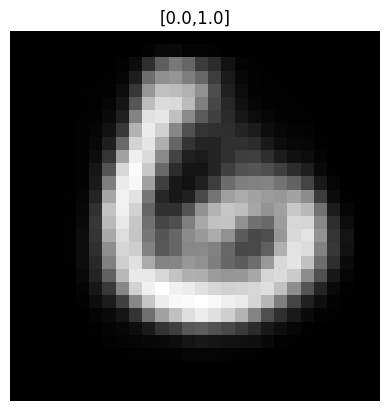

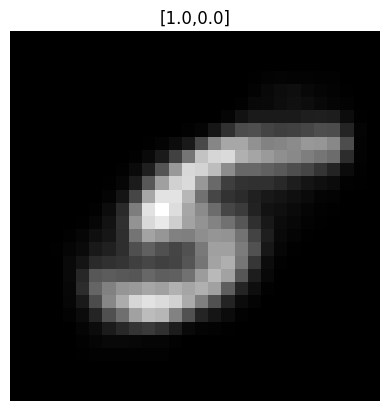

(None, None)

In [39]:
#img1: mean0, var1 / img2: mean1, var0
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

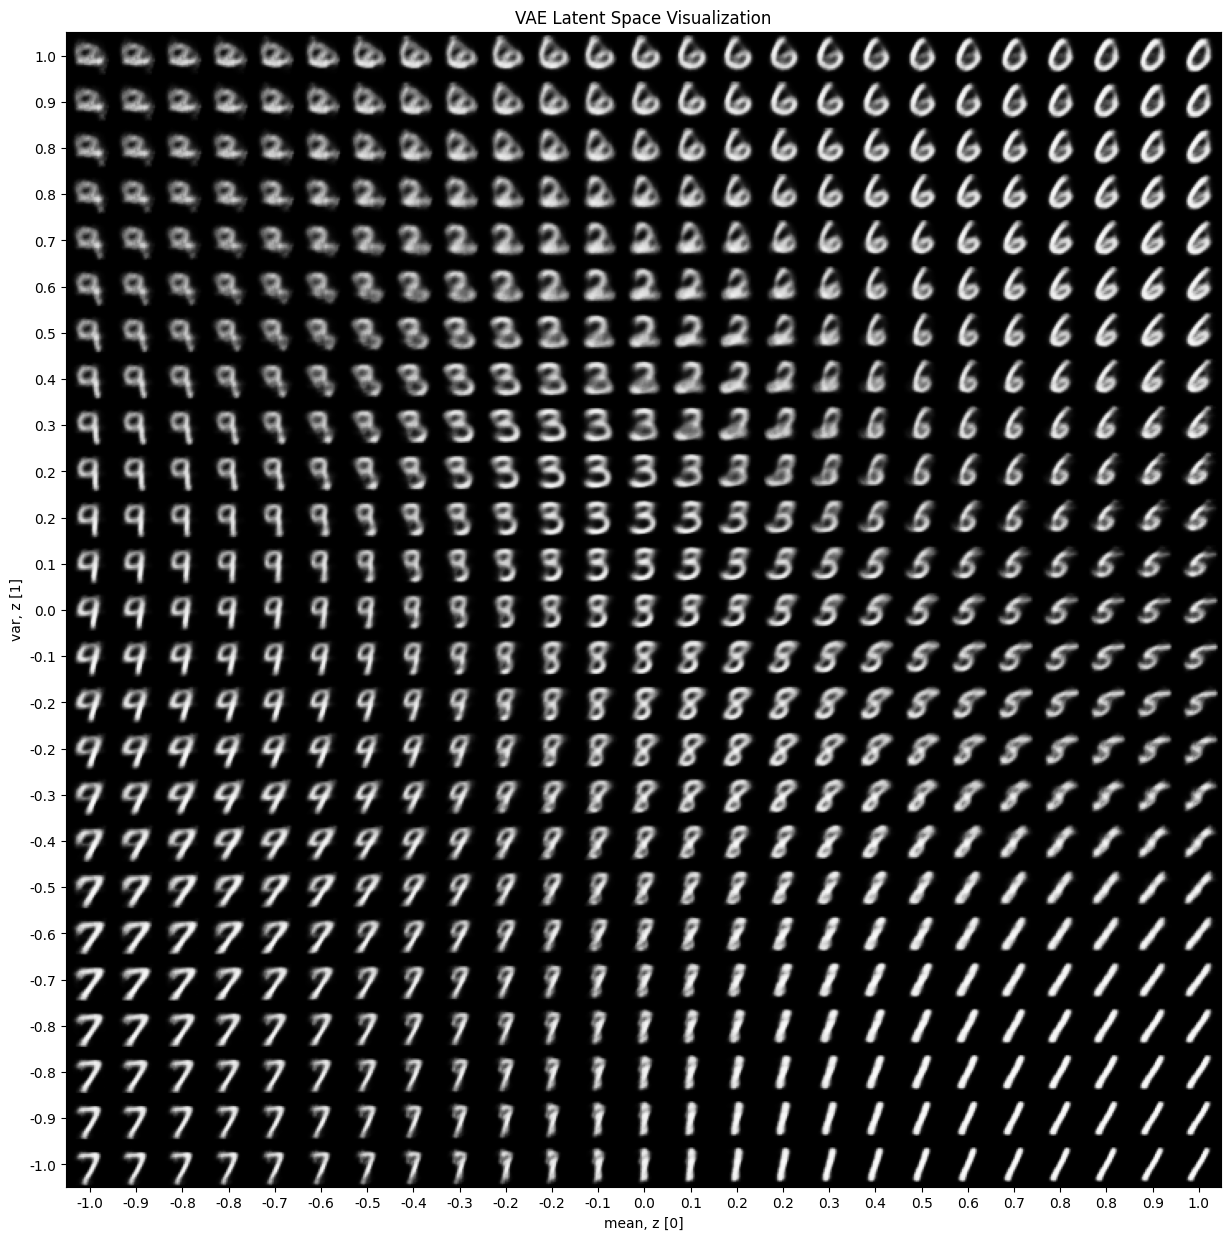

In [40]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

In [41]:
# Beta-GAN implementation
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [42]:
# Initialize and train Beta-GAN
latent_dim = 2
generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

adversarial_loss = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

def train_gan(generator, discriminator, dataloader, optimizer_G, optimizer_D, adversarial_loss, epochs=10):
    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(dataloader):
            valid = torch.ones(imgs.size(0), 1).cuda()
            fake = torch.zeros(imgs.size(0), 1).cuda()
            
            real_imgs = imgs.cuda()

            optimizer_G.zero_grad()
            z = torch.randn(imgs.size(0), latent_dim).cuda()
            gen_imgs = generator(z)
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)
            g_loss.backward()
            optimizer_G.step()

            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
        
        print(f'Epoch {epoch+1}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

In [9]:
train_gan(generator, discriminator, train_loader, optimizer_G, optimizer_D, adversarial_loss, epochs=10)

Epoch 1, D Loss: 0.22258859872817993, G Loss: 1.7180001735687256
Epoch 2, D Loss: 0.3597087264060974, G Loss: 3.349942445755005
Epoch 3, D Loss: 0.2569690942764282, G Loss: 4.660343170166016
Epoch 4, D Loss: 0.08760800957679749, G Loss: 7.559435844421387
Epoch 5, D Loss: 0.19886532425880432, G Loss: 1.7747957706451416
Epoch 6, D Loss: 0.235386461019516, G Loss: 1.41256582736969
Epoch 7, D Loss: 0.1451806277036667, G Loss: 3.403188705444336
Epoch 8, D Loss: 0.21218536794185638, G Loss: 4.007408142089844
Epoch 9, D Loss: 0.22891037166118622, G Loss: 2.0978167057037354
Epoch 10, D Loss: 0.171036496758461, G Loss: 2.9955615997314453


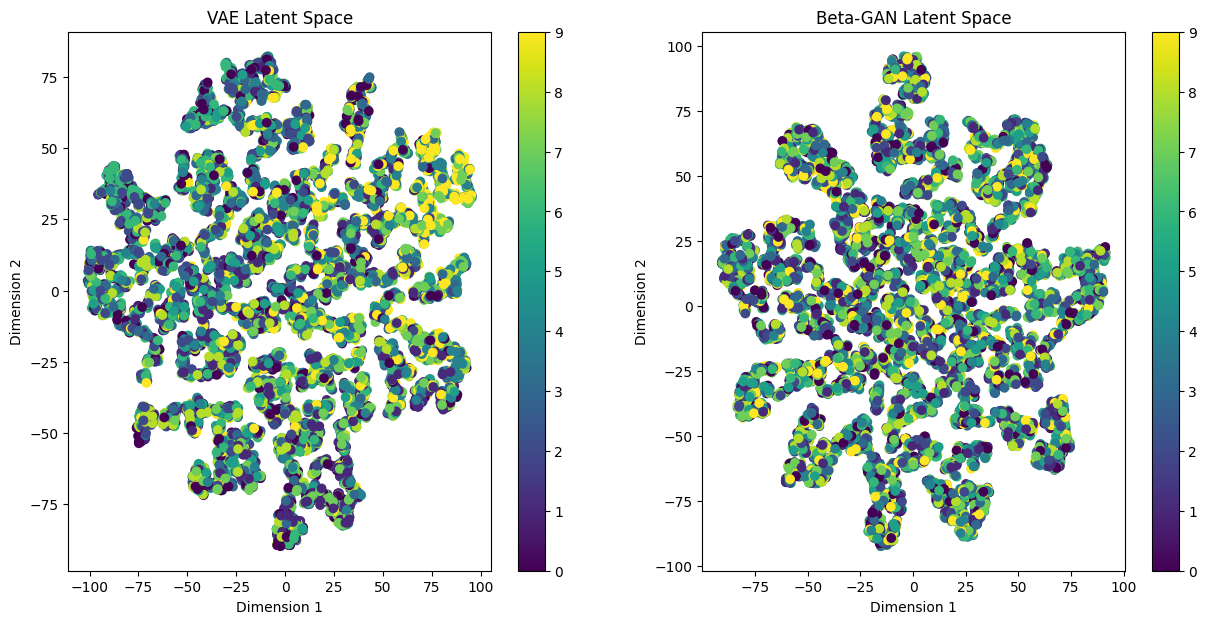

In [20]:
# Visualize the latent spaces
model.eval()
z_vae = []
labels = []
with torch.no_grad():
    for data, target in test_loader:
        data = data.cuda()
        mu, _ = model.encode(data)
        z_vae.append(mu.cpu().numpy())
        labels.append(target.numpy())
z_vae = np.concatenate(z_vae, axis=0)
labels = np.concatenate(labels, axis=0)

z_gan = torch.randn(len(test_dataset), latent_dim).cuda()
with torch.no_grad():
    gen_imgs = generator(z_gan).cpu().numpy()

# t-SNE visualization
tsne = TSNE(n_components=2)
z_vae_tsne = tsne.fit_transform(z_vae)
z_gan_tsne = tsne.fit_transform(z_gan.cpu().numpy())

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.scatter(z_vae_tsne[:, 0], z_vae_tsne[:, 1], c=labels, cmap='viridis')
plt.colorbar()
plt.title("VAE Latent Space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.subplot(1, 2, 2)
plt.scatter(z_gan_tsne[:, 0], z_gan_tsne[:, 1], c=labels, cmap='viridis')
plt.colorbar()
plt.title("Beta-GAN Latent Space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.show()

In [ ]:
"""
RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
"""